In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from tqdm import tqdm


import os
import pickle
import neurokit2 as nk
from tqdm import tqdm
from time import time
from hrvanalysis import get_frequency_domain_features

from utils.utils import ppg_findpeaks_bishop, rr_interval,\
                        exctract_hrv, exctract_hr, extract_p_wave,\
                        extract_sgr, ppg_amplitude, ppg_frequency 
plt.rcParams["figure.figsize"] = (20,10)

import warnings
warnings.filterwarnings("ignore")

In [2]:
from platform import python_version
print(python_version())

3.10.11


# Data

In [3]:
with open('new_dfs/df_separated_batch.pkl', 'rb') as f:
    df = pickle.load(f)
df

,Name,block,group,ECG,SGR,PPG,length
0,12_AlsGA_baseline.txt,baseline,Wrong_feedback,"[-0.0785, -0.069, -0.05225, -0.04825, -0.0565,...","[0.605774, 0.610352, 0.614929, 0.621033, 0.625...","[2.6225, 2.55125, 2.47812, 2.40437, 2.33, 2.25...",30235
1,12_AlsGA_block1.txt,block1_level1_batch0,Wrong_feedback,"[-0.05625, -0.064, -0.049, -0.041, -0.0535, -0...","[1.46942, 1.48773, 1.50604, 1.52435, 1.54114, ...","[1.805, 1.76188, 1.71875, 1.67563, 1.63188, 1....",1250
2,12_AlsGA_block1.txt,block1_level1_batch1,Wrong_feedback,"[-0.05225, -0.049, -0.0445, -0.04325, -0.0455,...","[4.1626, 4.19159, 4.21906, 4.24652, 4.27399, 4...","[1.91625, 1.86313, 1.81, 1.75688, 1.70375, 1.6...",1250
3,12_AlsGA_block1.txt,block1_level1_batch2,Wrong_feedback,"[-0.06425, -0.067, -0.0595, -0.048, -0.04025, ...","[-0.0778198, -0.0808716, -0.0839233, -0.085449...","[0.89125, 0.876875, 0.86375, 0.853125, 0.84562...",1250
4,12_AlsGA_block1.txt,block1_level1_batch3,Wrong_feedback,"[-0.02475, -0.0375, -0.03275, -0.02725, -0.037...","[-0.552368, -0.553894, -0.556946, -0.559998, -...","[0.666875, 0.661875, 0.6575, 0.653125, 0.64937...",1250
...,...,...,...,...,...,...,...
23914,59_ZolAI_training.txt,training_batch14,Wrong_feedback,"[-0.08975, -0.106, -0.11325, -0.09675, -0.074,...","[0.675964, 0.665283, 0.656128, 0.646973, 0.636...","[-0.508125, -0.5125, -0.5175, -0.52125, -0.524...",1250
23915,59_ZolAI_training.txt,training_batch15,Wrong_feedback,"[-0.0275, -0.00925, -0.0165, -0.02125, -0.0157...","[-0.790405, -0.782776, -0.775146, -0.765991, -...","[0.39375, 0.388125, 0.38125, 0.374375, 0.3675,...",1250
23916,59_ZolAI_training.txt,training_batch16,Wrong_feedback,"[0.0345, 0.04575, 0.08625, 0.08125, 0.055, 0.0...","[1.7746, 1.78528, 1.79443, 1.80511, 1.8158, 1....","[-0.3675, -0.37625, -0.384375, -0.39125, -0.39...",1250
23917,59_ZolAI_training.txt,training_batch17,Wrong_feedback,"[-0.01725, -0.035, -0.07475, -0.08825, -0.0695...","[0.67749, 0.665283, 0.654602, 0.642395, 0.6317...","[0.138125, 0.1675, 0.19375, 0.2175, 0.23875, 0...",1250


In [5]:
out = pd.read_csv('out_with_emotions.csv')
out

,Name,block,group,HRV,HR,PWave_amp,SGR_amp,PPG_amp,PPG_freq,LFHF_ratio,emotions
0,12_AlsGA_baseline.txt,baseline,Wrong_feedback,calm,calm,calm,calm,calm,calm,calm,calm
1,12_AlsGA_block1.txt,block1_level1_batch0,Wrong_feedback,increase,increase,increase,decrease,decrease,increase,increase,happiness
2,12_AlsGA_block1.txt,block1_level1_batch1,Wrong_feedback,increase,decrease,increase,decrease,decrease,increase,increase,sadness
3,12_AlsGA_block1.txt,block1_level1_batch2,Wrong_feedback,increase,decrease,increase,increase,decrease,increase,increase,sadness
4,12_AlsGA_block1.txt,block1_level1_batch3,Wrong_feedback,decrease,increase,increase,decrease,decrease,increase,increase,fear
...,...,...,...,...,...,...,...,...,...,...,...
23914,59_ZolAI_training.txt,training_batch14,Wrong_feedback,decrease,increase,increase,decrease,decrease,decrease,increase,fear
23915,59_ZolAI_training.txt,training_batch15,Wrong_feedback,decrease,increase,increase,increase,decrease,decrease,increase,fear
23916,59_ZolAI_training.txt,training_batch16,Wrong_feedback,calm,decrease,decrease,decrease,decrease,decrease,increase,calm
23917,59_ZolAI_training.txt,training_batch17,Wrong_feedback,calm,increase,increase,decrease,decrease,calm,increase,calm


# EDA

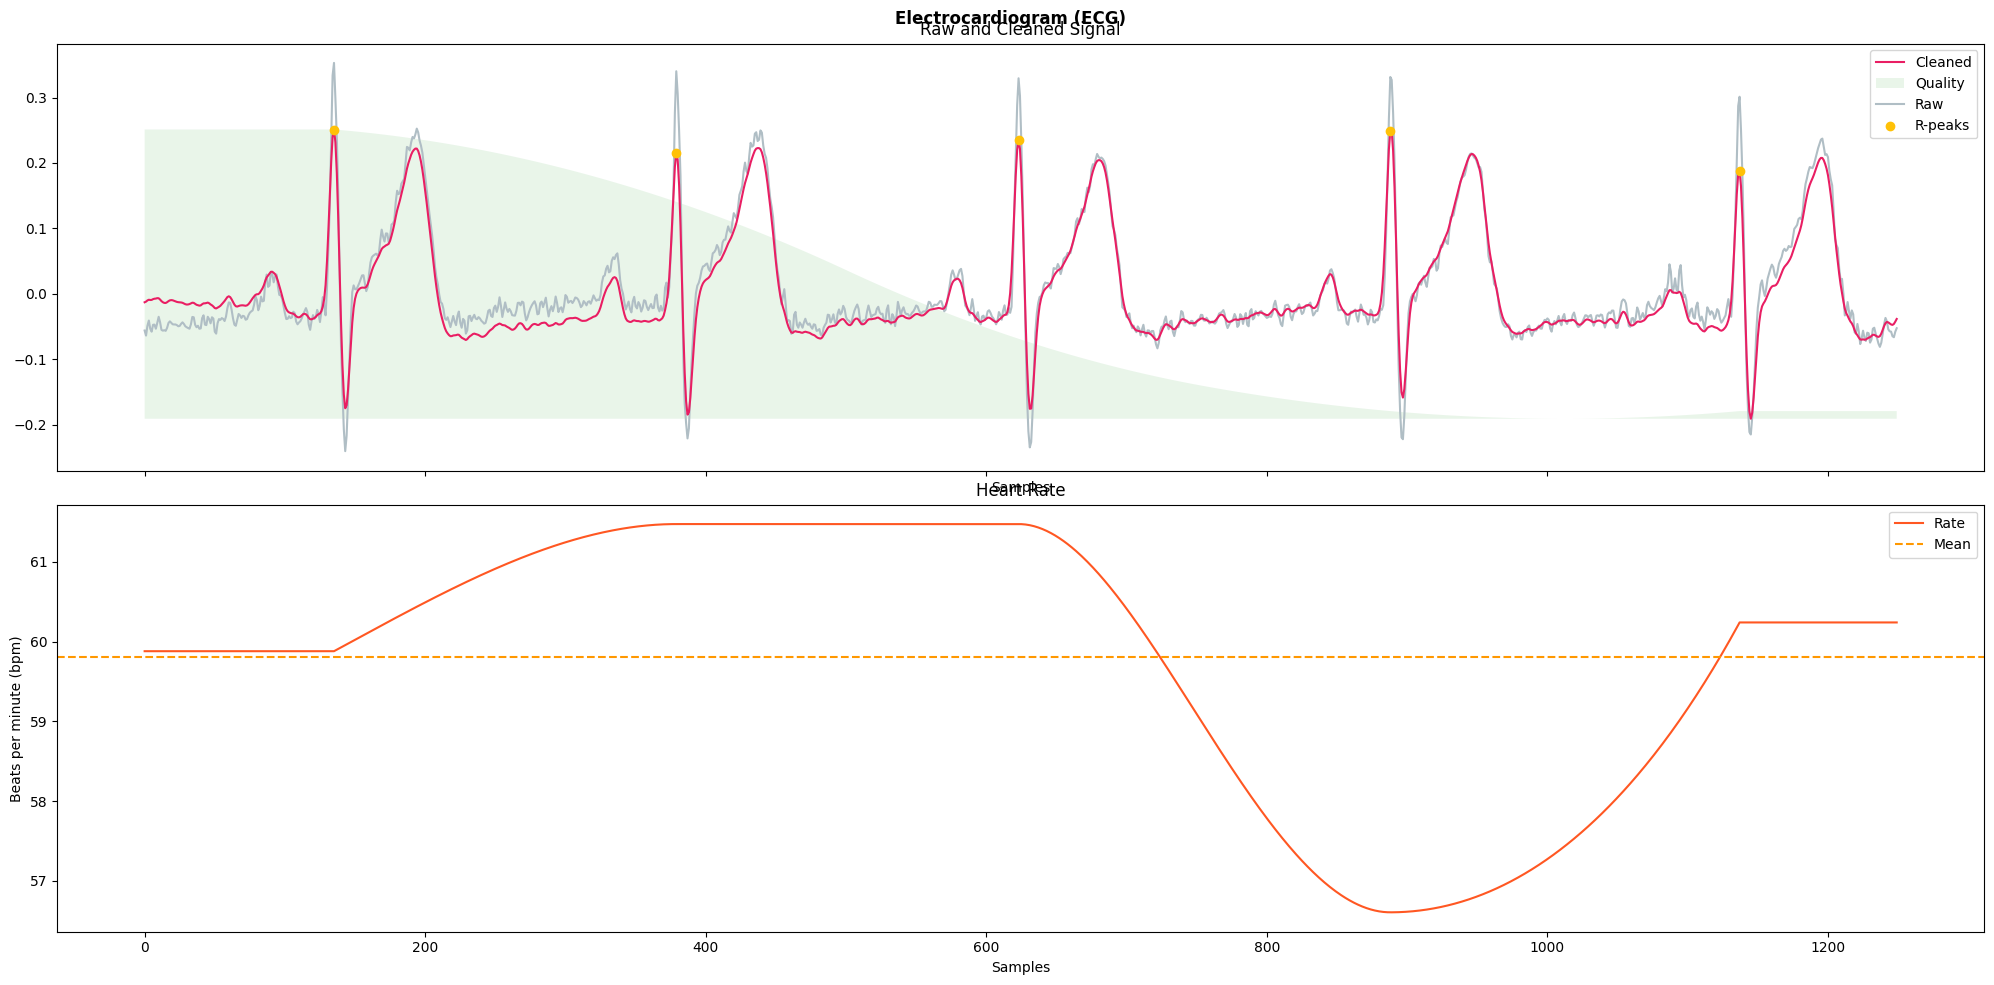

In [8]:
signals, info = nk.ecg_process(df['ECG'][1], sampling_rate=250)

# Visualize
nk.ecg_plot(signals)

In [6]:
tmp = out[out['Name'].str.contains('21')]
tmp.dropna(inplace = True)
tmp.reset_index(drop = True, inplace = True)

In [8]:
block1 = tmp[tmp.block.str.contains('block1')].index[-1]
block2 = tmp[tmp.block.str.contains('block2')].index[-1]
block3 = tmp[tmp.block.str.contains('block3')].index[-1]
training = tmp[tmp.block.str.contains('training')].index[-1]

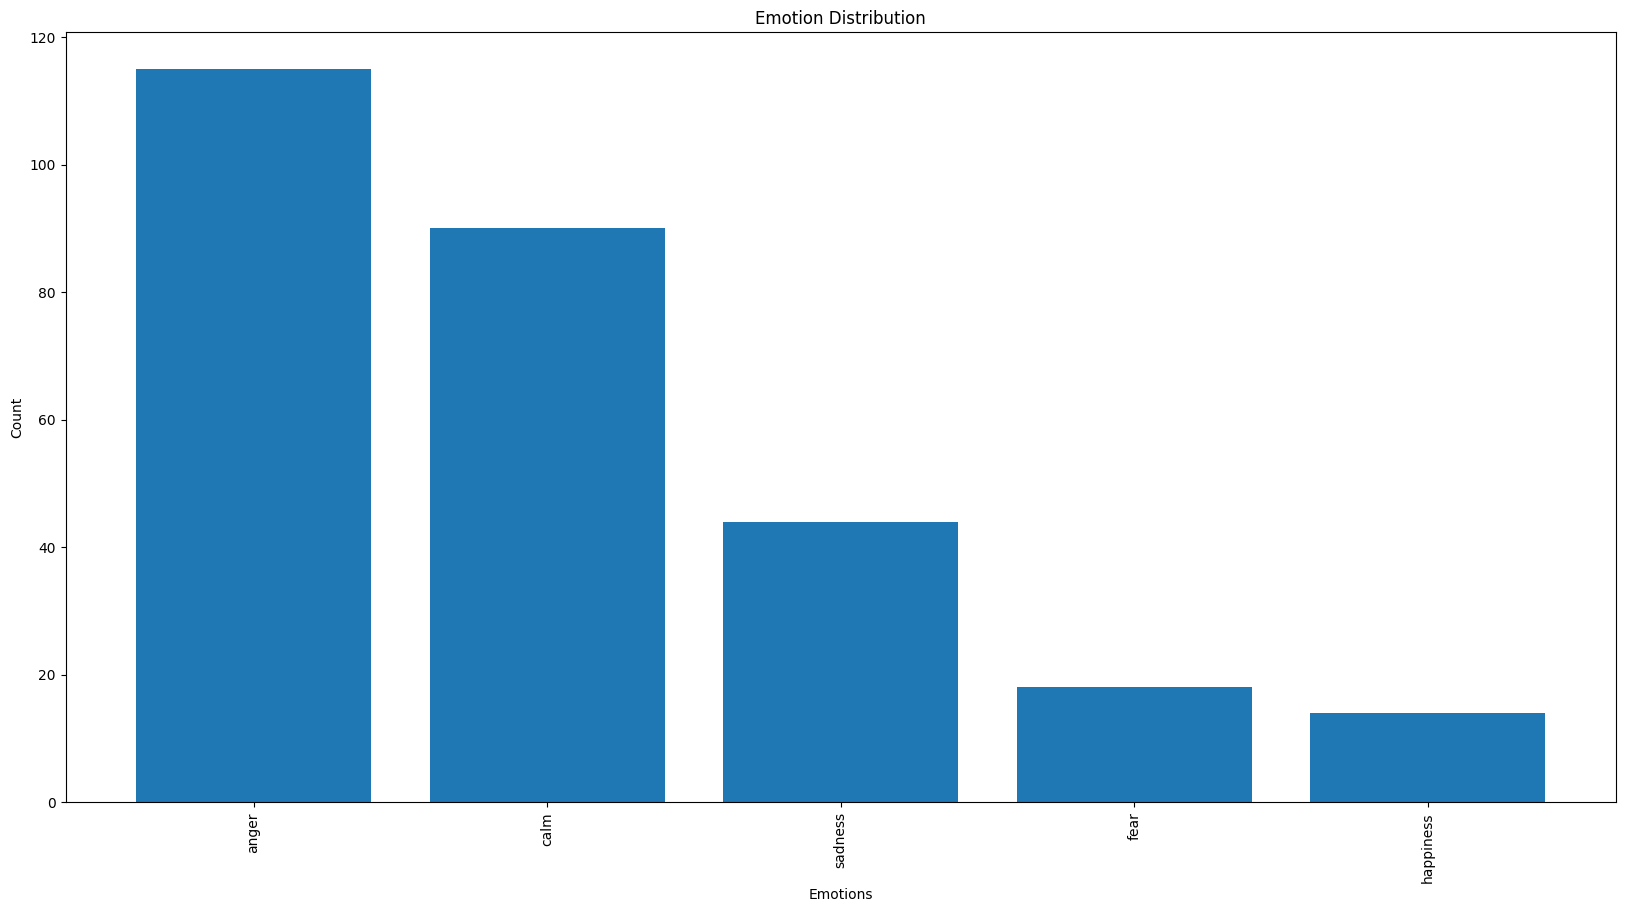

In [9]:
emotion_counts = tmp['emotions'].value_counts()

# Extract the emotion names and their respective counts
emotion_names = emotion_counts.index
emotion_values = emotion_counts.values

# Plotting the histogram
plt.bar(emotion_names, emotion_values)

# Customize the plot
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.title('Emotion Distribution')
plt.xticks(rotation=90)  # Rotate x-axis labels if needed

# Display the plot
plt.show()

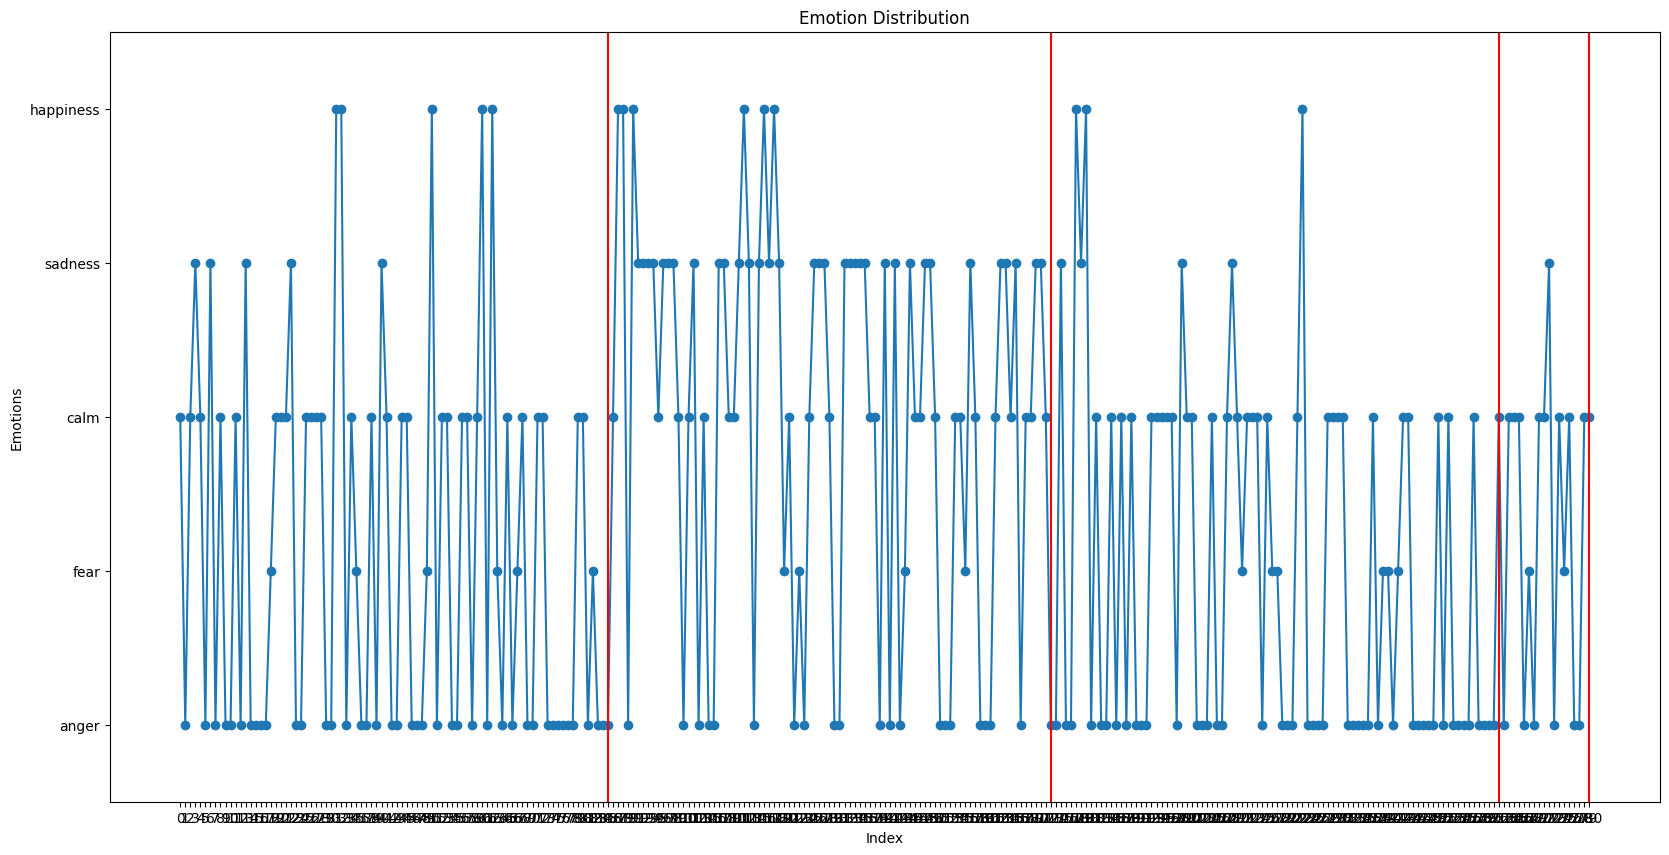

In [11]:
desired_order = ['anger', 'fear', 'calm', 'sadness', 'happiness']

emotions = tmp['emotions'].tolist()
values = range(len(emotions))

# Sort the emotions based on the desired order
emotion_positions = {emotion: i for i, emotion in enumerate(desired_order)}

# Assign the y-coordinates based on the desired order
y_coordinates = [emotion_positions[emotion] for emotion in emotions]

# Plotting the line graph
plt.plot(values, y_coordinates, marker='o')

# Customize the plot
plt.xlabel('Index')
plt.ylabel('Emotions')
plt.title('Emotion Distribution')
plt.xticks(range(len(emotions)), values)  # Set x-axis ticks to match values
plt.yticks(range(len(desired_order)), desired_order)  # Set y-axis ticks to match desired order
plt.ylim(-0.5, len(desired_order)-0.5)  # Adjust the y-axis limits to match desired order
plt.axvline(x=block1, color = 'red')
plt.axvline(x=block2, color = 'red')
plt.axvline(x=block3, color = 'red')
plt.axvline(x=training, color = 'red')
# Display the plot
plt.show()
plt.close()

# Create final df

In [12]:
out

,Name,block,group,HRV,HR,PWave_amp,SGR_amp,PPG_amp,PPG_freq,LFHF_ratio,emotions
0,12_AlsGA_baseline.txt,baseline,Wrong_feedback,calm,calm,calm,calm,calm,calm,calm,calm
1,12_AlsGA_block1.txt,block1_level1_batch0,Wrong_feedback,increase,increase,increase,decrease,decrease,increase,increase,happiness
2,12_AlsGA_block1.txt,block1_level1_batch1,Wrong_feedback,increase,decrease,increase,decrease,decrease,increase,increase,sadness
3,12_AlsGA_block1.txt,block1_level1_batch2,Wrong_feedback,increase,decrease,increase,increase,decrease,increase,increase,sadness
4,12_AlsGA_block1.txt,block1_level1_batch3,Wrong_feedback,decrease,increase,increase,decrease,decrease,increase,increase,fear
...,...,...,...,...,...,...,...,...,...,...,...
23914,59_ZolAI_training.txt,training_batch14,Wrong_feedback,decrease,increase,increase,decrease,decrease,decrease,increase,fear
23915,59_ZolAI_training.txt,training_batch15,Wrong_feedback,decrease,increase,increase,increase,decrease,decrease,increase,fear
23916,59_ZolAI_training.txt,training_batch16,Wrong_feedback,calm,decrease,decrease,decrease,decrease,decrease,increase,calm
23917,59_ZolAI_training.txt,training_batch17,Wrong_feedback,calm,increase,increase,decrease,decrease,calm,increase,calm


In [6]:
final_df = pd.concat([df,out.drop(['Name','block','group'],axis =1)], axis = 1)

In [7]:
good_people = [5,6,8,11,12,16,17,21,22,28, 29, 31, 32, 34, 37, 46, 47, 49, 55, 57, 58, 60, 61, 62, 65, 66, 67, 68, 70, 73, 3,7,9,13,19,25,42,51,52,59,63, 69, 30,53,54,71]

In [8]:
output_df = pd.DataFrame()
for number in good_people:
    if len(str(number)) == 1:
        output_df = pd.concat([output_df, final_df[final_df['Name'].str.contains('0{}'.format(number))]])
    else:
        output_df = pd.concat([output_df, final_df[final_df['Name'].str.contains('{}'.format(number))]])
    

In [9]:
output_df.dropna(inplace = True)
output_df.reset_index(drop = True, inplace = True)
output_df

,Name,block,group,ECG,SGR,PPG,length,HRV,HR,PWave_amp,SGR_amp,PPG_amp,PPG_freq,LFHF_ratio,emotions
0,05_SubAA_baseline.txt,baseline,Wrong_feedback,"[-0.05825, -0.0455, -0.03475, -0.0455, -0.054,...","[0.1297, 0.1297, 0.1297, 0.1297, 0.1297, 0.129...","[-0.15, -0.148125, -0.14625, -0.14375, -0.1412...",31354,calm,calm,calm,calm,calm,calm,calm,calm
1,05_SubAA_block1.txt,block1_level1_batch0,Wrong_feedback,"[-0.0215, -0.01825, -0.02175, -0.01475, 0.0015...","[-1.00861, -1.00555, -1.0025, -0.999451, -0.99...","[0.030625, 0.02625, 0.021875, 0.018125, 0.015,...",1250,decrease,increase,increase,increase,decrease,decrease,increase,fear
2,05_SubAA_block1.txt,block1_level1_batch1,Wrong_feedback,"[-0.04275, -0.04325, -0.02975, -0.032, -0.0427...","[-0.846863, -0.848389, -0.849915, -0.85144, -0...","[0.1525, 0.160625, 0.1675, 0.1725, 0.175625, 0...",1250,decrease,increase,increase,increase,decrease,decrease,increase,fear
3,05_SubAA_block1.txt,block1_level1_batch2,Wrong_feedback,"[-0.02325, -0.02, -0.03, -0.031, -0.023, -0.02...","[0.45929, 0.453186, 0.447083, 0.440979, 0.4348...","[-0.14875, -0.151875, -0.1525, -0.15125, -0.14...",1250,decrease,decrease,increase,decrease,decrease,decrease,increase,fear
4,05_SubAA_block1.txt,block1_level1_batch3,Wrong_feedback,"[-0.02675, -0.0375, -0.04825, -0.04375, -0.042...","[2.25067, 2.23999, 2.23083, 2.22015, 2.20947, ...","[0.164375, 0.166875, 0.17, 0.1725, 0.174375, 0...",1250,decrease,decrease,increase,decrease,decrease,decrease,increase,fear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12816,71_KruIA_training.txt,training_batch13,Wrong_feedback,"[-0.0535, -0.053, -0.0665, -0.07275, -0.0745, ...","[-0.932312, -0.932312, -0.933838, -0.933838, -...","[-0.120625, -0.11875, -0.1175, -0.1175, -0.118...",1250,increase,decrease,decrease,decrease,calm,calm,increase,happiness
12817,71_KruIA_training.txt,training_batch14,Wrong_feedback,"[-0.05525, -0.056, -0.051, -0.05975, -0.082, -...","[-0.648499, -0.648499, -0.646973, -0.646973, -...","[0.186875, 0.188125, 0.18875, 0.18875, 0.18875...",1250,calm,increase,decrease,increase,increase,calm,increase,calm
12818,71_KruIA_training.txt,training_batch15,Wrong_feedback,"[0.1785, 0.19575, 0.2, 0.217, 0.241, 0.25175, ...","[-0.430298, -0.427246, -0.42572, -0.424194, -0...","[-0.305, -0.30875, -0.3125, -0.31625, -0.32, -...",1250,calm,decrease,increase,decrease,increase,calm,increase,calm
12819,71_KruIA_training.txt,training_batch16,Wrong_feedback,"[-0.05825, -0.0535, -0.052, -0.0505, -0.04825,...","[-0.535583, -0.537109, -0.538635, -0.540161, -...","[0.514375, 0.514375, 0.515625, 0.518125, 0.520...",1250,calm,decrease,decrease,increase,increase,calm,increase,calm


In [11]:
output_df.drop(['block', 'group', 'ECG', 'SGR', 'PPG', 'length', 'emotions'], axis = 1).to_csv('new_dfs/binary_features.csv', index = False)

# Features

In [43]:
def extract_numerical_features(df):
    new_df = pd.DataFrame()
    for i in tqdm(range(len(df))):
        try:
            signals, info = nk.ecg_process(output_df["ECG"][i], sampling_rate=250)
            analyze_df = nk.ecg_analyze(signals, sampling_rate=250, method = 'interval')
            row = {'ECG_Rate_Mean' : analyze_df['ECG_Rate_Mean'].item(),
                   'HRV_MeanNN' : analyze_df['HRV_MeanNN'].item(),
                   'HRV_SDNN' : analyze_df['HRV_SDNN'].item(),
                   'HRV_RMSSD' : analyze_df['HRV_RMSSD'].item(),
                   'HRV_pNN50' : analyze_df['HRV_pNN50'].item()
                  }
            new_df = pd.concat([new_df,pd.DataFrame([row])],ignore_index = True)
        except:
            row = {'ECG_Rate_Mean' : np.nan,
                   'HRV_MeanNN' : np.nan,
                   'HRV_SDNN' : np.nan,
                   'HRV_RMSSD' : np.nan,
                   'HRV_pNN50' : np.nan
                  }
            new_df = pd.concat([new_df,pd.DataFrame([row])],ignore_index = True)
    return new_df
            

In [30]:
new_df = extract_numerical_features(output_df)

100%|████████████████████████████████████████████████████████████████████████████| 12821/12821 [41:27<00:00,  5.15it/s]


In [39]:
final_df = pd.concat([output_df, new_df], axis = 1)
final_df.drop(['HRV','HR', 'PWave_amp', 'SGR_amp', 'PPG_amp','PPG_freq', 'LFHF_ratio'], axis = 1, inplace = True)

In [3]:
with open('new_dfs/final_df.pkl', 'rb') as f:
    final_df = pickle.load(f)
final_df

,Name,block,group,ECG,SGR,PPG,length,emotions,ECG_Rate_Mean,HRV_MeanNN,HRV_SDNN,HRV_RMSSD,HRV_pNN50
0,05_SubAA_baseline.txt,baseline,Wrong_feedback,"[-0.05825, -0.0455, -0.03475, -0.0455, -0.054,...","[0.1297, 0.1297, 0.1297, 0.1297, 0.1297, 0.129...","[-0.15, -0.148125, -0.14625, -0.14375, -0.1412...",31354,calm,61.712855,972.34375,31.367880,33.180964,15.625
1,05_SubAA_block1.txt,block1_level1_batch0,Wrong_feedback,"[-0.0215, -0.01825, -0.02175, -0.01475, 0.0015...","[-1.00861, -1.00555, -1.0025, -0.999451, -0.99...","[0.030625, 0.02625, 0.021875, 0.018125, 0.015,...",1250,fear,66.284634,905.00000,14.375906,18.761663,0.000
2,05_SubAA_block1.txt,block1_level1_batch1,Wrong_feedback,"[-0.04275, -0.04325, -0.02975, -0.032, -0.0427...","[-0.846863, -0.848389, -0.849915, -0.85144, -0...","[0.1525, 0.160625, 0.1675, 0.1725, 0.175625, 0...",1250,fear,64.948825,924.00000,8.640988,10.583005,0.000
3,05_SubAA_block1.txt,block1_level1_batch2,Wrong_feedback,"[-0.02325, -0.02, -0.03, -0.031, -0.023, -0.02...","[0.45929, 0.453186, 0.447083, 0.440979, 0.4348...","[-0.14875, -0.151875, -0.1525, -0.15125, -0.14...",1250,fear,66.135005,906.00000,18.036999,31.411251,0.000
4,05_SubAA_block1.txt,block1_level1_batch3,Wrong_feedback,"[-0.02675, -0.0375, -0.04825, -0.04375, -0.042...","[2.25067, 2.23999, 2.23083, 2.22015, 2.20947, ...","[0.164375, 0.166875, 0.17, 0.1725, 0.174375, 0...",1250,fear,68.422172,876.00000,12.000000,18.439089,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12816,71_KruIA_training.txt,training_batch13,Wrong_feedback,"[-0.0535, -0.053, -0.0665, -0.07275, -0.0745, ...","[-0.932312, -0.932312, -0.933838, -0.933838, -...","[-0.120625, -0.11875, -0.1175, -0.1175, -0.118...",1250,happiness,63.077427,950.00000,29.664794,40.463976,25.000
12817,71_KruIA_training.txt,training_batch14,Wrong_feedback,"[-0.05525, -0.056, -0.051, -0.05975, -0.082, -...","[-0.648499, -0.648499, -0.646973, -0.646973, -...","[0.186875, 0.188125, 0.18875, 0.18875, 0.18875...",1250,calm,66.351505,906.00000,30.897681,40.792156,25.000
12818,71_KruIA_training.txt,training_batch15,Wrong_feedback,"[0.1785, 0.19575, 0.2, 0.217, 0.241, 0.25175, ...","[-0.430298, -0.427246, -0.42572, -0.424194, -0...","[-0.305, -0.30875, -0.3125, -0.31625, -0.32, -...",1250,calm,65.290771,920.00000,44.181444,49.044198,25.000
12819,71_KruIA_training.txt,training_batch16,Wrong_feedback,"[-0.05825, -0.0535, -0.052, -0.0505, -0.04825,...","[-0.535583, -0.537109, -0.538635, -0.540161, -...","[0.514375, 0.514375, 0.515625, 0.518125, 0.520...",1250,calm,64.180653,934.00000,33.704599,46.360903,50.000


In [4]:
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import settings

In [66]:
settings_minimal = settings.MinimalFCParameters()
settings_minimal
settings_time = settings.TimeBasedFCParameters()
settings_time.update(settings_minimal)
settings_time
settings_efficient = settings.EfficientFCParameters()
settings_efficient
settings_comprehensive = settings.ComprehensiveFCParameters()
len(settings_comprehensive)

75

In [68]:
data_long = pd.DataFrame()
for i, ts in enumerate(tqdm(final_df['ECG'].values.flatten())):
    data = [[x, i] for x in ts]
    data_long = pd.concat([data_long, pd.DataFrame(data)], ignore_index=True)
data_long.columns = ['value', 'id']

100%|████████████████████████████████████████████████████████████████████████████| 12821/12821 [09:40<00:00, 22.07it/s]


In [69]:
data_long

,value,id
0,-0.05825,0
1,-0.04550,0
2,-0.03475,0
3,-0.04550,0
4,-0.05400,0
...,...,...
17283159,-0.33025,12820
17283160,-0.34425,12820
17283161,-0.32050,12820
17283162,-0.27000,12820


In [70]:
extracted_features = extract_features(data_long, column_id='id', impute_function=impute, default_fc_parameters=settings_efficient)
print(extracted_features.shape)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 20/20 [15:41<00:00, 47.05s/it]


(12821, 777)


In [71]:
extracted_features

,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__query_similarity_count__query_None__threshold_0.0,value__mean_n_absolute_max__number_of_maxima_7
0,0.0,0.0,0.0,1.0,-107.53175,64.655742,0.007106,2.950276e-07,-1.594795e-08,-0.019250,...,0.215617,0.363346,1.055041,1.648034,2.771385,3.989198,5.275674,6.563572,0.0,0.173571
1,0.0,0.0,0.0,1.0,-0.35650,2.866557,0.008619,-8.206565e-06,2.403846e-06,-0.015750,...,0.249958,0.397431,1.109353,1.664827,2.810548,4.011452,5.181073,6.071365,0.0,0.166571
2,0.0,0.0,1.0,1.0,7.73700,2.724017,0.008359,5.804644e-06,1.201923e-06,-0.007375,...,0.245901,0.397431,1.155477,1.670504,2.811650,4.039434,5.235201,6.138978,0.0,0.181571
3,0.0,0.0,0.0,1.0,2.17300,2.903062,0.010481,-9.007206e-06,2.303686e-06,-0.011750,...,0.280179,0.359290,1.138040,1.688271,2.836178,4.079765,5.273136,6.168202,0.0,0.165071
4,0.0,0.0,0.0,1.0,-1.35375,2.623250,0.009434,2.682146e-05,4.106571e-06,-0.015375,...,0.245901,0.422803,1.133984,1.667847,2.799983,4.015058,5.200381,6.123996,0.0,0.167536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12816,0.0,0.0,0.0,1.0,-3.74150,20.914419,0.016557,-2.201761e-06,5.308494e-06,-0.045000,...,0.425790,0.732657,1.408042,1.591131,2.654048,3.772444,4.844714,5.668527,0.0,0.672500
12817,0.0,0.0,0.0,1.0,-2.96150,22.672171,0.018002,1.661329e-04,5.308494e-06,-0.045875,...,0.357079,0.663578,1.390605,1.546160,2.560292,3.618028,4.632310,5.443000,0.0,0.663536
12818,0.0,0.0,0.0,1.0,-1.30450,21.705698,0.015837,-1.923539e-04,-7.411859e-06,-0.048500,...,0.333204,0.655002,1.354201,1.565982,2.593161,3.665628,4.700764,5.529256,0.0,0.657643
12819,0.0,0.0,0.0,1.0,-1.78675,22.755917,0.017999,1.114892e-04,1.001603e-06,-0.047875,...,0.421225,0.683846,1.369112,1.588887,2.643520,3.739116,4.817655,5.668757,0.0,0.669286


In [77]:
extracted_features.to_csv('new_dfs/ecg_features.csv', index = False)

In [73]:
extracted_features.set_index(final_df.index, inplace = True)

In [78]:
relevant_features = set()

for label in final_df['emotions'].unique():
    # select_features работает с бинарной классификацией, поэтому переводим задачу
    # в бинарную для каждого класса и повторяем по всем классам
    y_train_binary = y_train == label
    X_train_filtered = select_features(extracted_features, y_train_binary)
    relevant_features = relevant_features.union(set(X_train_filtered.columns))

len(relevant_features)

332

In [79]:
relevant_features

{'value__abs_energy',
 'value__absolute_maximum',
 'value__absolute_sum_of_changes',
 'value__agg_autocorrelation__f_agg_"mean"__maxlag_40',
 'value__agg_autocorrelation__f_agg_"median"__maxlag_40',
 'value__agg_autocorrelation__f_agg_"var"__maxlag_40',
 'value__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max"',
 'value__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean"',
 'value__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min"',
 'value__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"',
 'value__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"',
 'value__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean"',
 'value__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min"',
 'value__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var"',
 'value__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max"',
 'value__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean"',
 'value__agg_li

In [80]:
extracted_features_filtered = extracted_features[list(relevant_features)]
extracted_features_filtered

,"value__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.4","value__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""var""","value__fft_coefficient__attr_""abs""__coeff_1",value__c3__lag_2,"value__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.6","value__change_quantiles__f_agg_""var""__isabs_False__qh_0.4__ql_0.2","value__fft_coefficient__attr_""abs""__coeff_7","value__fft_coefficient__attr_""abs""__coeff_85",value__sum_of_reoccurring_data_points,"value__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20)",...,"value__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""mean""",value__ratio_beyond_r_sigma__r_2,"value__fft_coefficient__attr_""abs""__coeff_16",value__range_count__max_1000000000000.0__min_0,"value__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.2","value__change_quantiles__f_agg_""var""__isabs_True__qh_0.6__ql_0.4",value__spkt_welch_density__coeff_2,"value__fft_coefficient__attr_""real""__coeff_86",value__large_standard_deviation__r_0.1,"value__agg_linear_trend__attr_""rvalue""__chunk_len_50__f_agg_""max"""
0,0.000018,0.000140,65.075161,0.000087,0.000017,0.000013,17.515078,1.664386,-113.82525,-0.085602,...,-0.008457,0.079129,12.066136,9651.0,0.000020,0.000007,0.091741,3.201595,1.0,0.035170
1,0.000023,0.000279,6.462044,0.000090,0.000024,0.000016,4.530184,2.393689,-10.34775,0.010994,...,0.000517,0.080800,6.521677,446.0,0.000023,0.000008,0.094210,-0.091294,1.0,0.068071
2,0.000027,0.000262,10.146500,0.000129,0.000019,0.000017,4.092636,1.474783,-2.68350,-0.080885,...,0.004825,0.072000,12.579567,514.0,0.000027,0.000011,0.080973,-0.885810,1.0,0.048626
3,0.000047,0.000294,7.027022,0.000092,0.000033,0.000026,4.969437,0.446001,-6.25525,-0.034894,...,-0.008701,0.071200,7.794762,486.0,0.000048,0.000017,0.104255,1.428978,1.0,0.049417
4,0.000030,0.000188,3.975436,0.000083,0.000026,0.000016,2.719329,2.206473,-10.79625,-0.103777,...,-0.001374,0.077600,1.913211,432.0,0.000032,0.000010,0.087521,-0.392644,1.0,0.056180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12816,0.000055,0.002162,6.382015,0.001998,0.000080,0.000039,3.794096,6.690178,-29.54700,-0.114849,...,-0.009990,0.077600,31.746270,357.0,0.000049,0.000015,0.324870,-11.900259,1.0,0.010871
12817,0.000089,0.001641,2.254358,0.001863,0.000067,0.000039,10.603901,6.262511,-29.73800,-0.194498,...,-0.003145,0.075200,11.537407,387.0,0.000074,0.000019,0.599844,3.293065,1.0,-0.032076
12818,0.000089,0.001338,3.484275,0.002065,0.000107,0.000033,17.950483,7.008928,-33.61850,1.156235,...,0.003296,0.080800,28.614715,374.0,0.000067,0.000012,0.424893,-1.884461,1.0,0.055122
12819,0.000083,0.001897,5.193474,0.002066,0.000064,0.000031,16.803203,4.462765,-32.48425,-0.160739,...,0.009701,0.075200,23.147494,370.0,0.000071,0.000017,0.530499,-0.040776,1.0,-0.035659


In [81]:
extracted_features_filtered.to_csv('features_filtered.csv', index = False)

In [42]:
final_df.to_pickle('new_dfs/final_df.pkl')